# 📊 Análisis Exploratorio del Mercado Laboral LatAm

Este notebook sirve como un punto de partida para explorar los datos recopilados por el scraper de vacantes. Utilizaremos `pandas` para la manipulación de datos y `plotly` para visualizaciones interactivas.

In [1]:
import pandas as pd
import plotly.express as px
import os
from dotenv import load_dotenv
import datetime
# import streamlit as st # NO ES NECESARIO EN JUPYTER

# Asegúrate de que estás en la raíz del proyecto o ajusta la ruta
load_dotenv()

# Importar el cliente de Supabase (asumiendo que los paths están correctos)
try:
    from database.supabase_client import SupabaseClient
except ImportError:
    # Ajusta la ruta si es necesario para el contexto del notebook
    import sys
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
    from database.supabase_client import SupabaseClient

print("Librerías cargadas exitosamente.")

Librerías cargadas exitosamente.


## 1. Cargar Datos desde Supabase

Primero, estableceremos una conexión a Supabase y cargaremos los datos de las vacantes (`jobs`) y las tendencias (`trends`).

In [2]:
supabase_client = SupabaseClient()

# @st.cache_data(ttl=3600) # ESTA LÍNEA DEBE SER COMENTADA O ELIMINADA EN JUPYTER
def load_all_data_for_notebook(): # Renombramos la función para distinguirla de la del dashboard
    print("Cargando datos de trabajos de Supabase...")
    jobs_response = supabase_client.get_jobs(limit=None)
    jobs_data = jobs_response.data if jobs_response and jobs_response.data else []
    df_jobs = pd.DataFrame(jobs_data)
    
    print("Cargando datos de tendencias de Supabase...")
    trends_response = supabase_client.get_trends(limit=None)
    trends_data = trends_response.data if trends_response and trends_response.data else []
    df_trends = pd.DataFrame(trends_data)

    # Convertir columnas de fecha
    if 'posted_date' in df_jobs.columns: df_jobs['posted_date'] = pd.to_datetime(df_jobs['posted_date'], errors='coerce')
    if 'scraped_at' in df_jobs.columns: df_jobs['scraped_at'] = pd.to_datetime(df_jobs['scraped_at'], errors='coerce')
    if 'date' in df_trends.columns: df_trends['date'] = pd.to_datetime(df_trends['date'], errors='coerce')
    
    # Limpiar posibles zonas horarias para consistencia
    for col in ['posted_date', 'scraped_at']:
        if col in df_jobs.columns and df_jobs[col].dt.tz is not None:
            df_jobs[col] = df_jobs[col].dt.tz_localize(None)
    if 'date' in df_trends.columns and df_trends['date'].dt.tz is not None:
        df_trends['date'] = df_trends['date'].dt.tz_localize(None)

    # Procesar habilidades anidadas si existen
    if 'skills' in df_jobs.columns and not df_jobs['skills'].empty:
        all_skills_flat = []
        for idx, row in df_jobs.iterrows():
            if row['skills']:
                for skill_entry in row['skills']:
                    all_skills_flat.append({
                        'job_id': row['id'],
                        'skill_name': skill_entry.get('skill_name'),
                        'skill_category': skill_entry.get('skill_category'),
                        'posted_date': row['posted_date'],
                        'country': row['country'],
                        'sector': row['sector'],
                    })
        df_skills = pd.DataFrame(all_skills_flat)
    else:
        df_skills = pd.DataFrame()

    print(f"Jobs cargados: {len(df_jobs)} registros")
    print(f"Skills cargados: {len(df_skills)} registros")
    print(f"Tendencias cargados: {len(df_trends)} registros")

    return df_jobs, df_skills, df_trends

df_jobs, df_skills, df_trends = load_all_data_for_notebook()

Cargando datos de trabajos de Supabase...


2025-12-08 11:58:59,311 - INFO - HTTP Request: GET https://glefextdcgtgabqjtfcp.supabase.co/rest/v1/jobs?select=%2A%2Cskills%28%2A%29&order=scraped_at.desc "HTTP/2 200 OK"


Cargando datos de tendencias de Supabase...


2025-12-08 11:58:59,689 - INFO - HTTP Request: GET https://glefextdcgtgabqjtfcp.supabase.co/rest/v1/trends?select=%2A&order=date.desc "HTTP/2 200 OK"


Jobs cargados: 10 registros
Skills cargados: 142 registros
Tendencias cargados: 93 registros


## 2. Inspección Inicial de Datos

In [3]:
print("### DataFrame de Vacantes (df_jobs) - Primeras 5 filas ###")
display(df_jobs.head())

print("\n### Información de df_jobs ###")
df_jobs.info()

print("\n### DataFrame de Habilidades (df_skills) - Primeras 5 filas ###")
display(df_skills.head())

print("\n### Información de df_skills ###")
df_skills.info()

print("\n### DataFrame de Tendencias (df_trends) - Primeras 5 filas ###")
display(df_trends.head())

print("\n### Información de df_trends ###")
df_trends.info()

### DataFrame de Vacantes (df_jobs) - Primeras 5 filas ###


,id,job_id,title,company_name,location,country,job_type,seniority_level,sector,description,requirements,salary_range,posted_date,source_url,source_platform,scraped_at,is_active,skills
0,dfa4192e-9362-445b-b3aa-42894720cbb7,6BC19B08E451918E61373E686DCF3405,Ref. 20597: Machine Learning IA Enginerr - Hib...,Empresa Confidencial,None,Argentina,Full-time,Other,Machine Learning,Oferta Empresa Evaluaciones Salarios Ofertas s...,,None,2025-12-08,https://ar.computrabajo.com/ofertas-de-trabajo...,Computrabajo,2025-12-08 10:33:05.007660,True,[{'id': '5b758de3-2673-4966-80fe-d50b4e39e2d3'...
1,cbf53ded-9136-4b40-9209-e2ae5aa77865,CA93B3224473D5E861373E686DCF3405,Ref. 20616: Desarrolladores Java - Inglés avan...,Empresa Confidencial,None,Argentina,Full-time,Other,Kotlin,Oferta Empresa Evaluaciones Salarios Ofertas s...,Requisitos técnicos: Back-End: -Dominio de Jav...,None,2025-12-08,https://ar.computrabajo.com/ofertas-de-trabajo...,Computrabajo,2025-12-08 10:33:01.620718,True,[{'id': '43777303-1c47-4e9b-9b51-84638b5f3e68'...
2,129e238b-2072-4e19-840f-075d455c422c,CCC93FAEDF11201A61373E686DCF3405,Ref. 20616: Desarrolladores Java o React ingle...,Empresa Confidencial,None,Argentina,Full-time,Other,Kotlin,Oferta Empresa Evaluaciones Salarios Ofertas s...,Requisitos técnicos: Front-End: -Experiencia e...,None,2025-12-08,https://ar.computrabajo.com/ofertas-de-trabajo...,Computrabajo,2025-12-08 10:32:57.904658,True,[{'id': 'dfb6f25a-2bde-45b4-a832-a0c09b9a9dfb'...
3,dae70350-b2b7-4bc5-af3c-44bf60abea3c,076E4DB898F171B861373E686DCF3405,Ref. 20616: Desarrolladores Java ingles avanza...,Empresa Confidencial,None,Argentina,Full-time,Other,Kotlin,Oferta Empresa Evaluaciones Salarios Ofertas s...,Requisitos técnicos: -Dominio de Java o Kotlin...,None,2025-12-08,https://ar.computrabajo.com/ofertas-de-trabajo...,Computrabajo,2025-12-08 10:32:54.115792,True,[{'id': 'f14c52cf-911a-4604-baf7-b06e43e19697'...
4,6e1fdc1f-82e5-491c-8a3c-dff9a00a2081,40B7C489A732B63D61373E686DCF3405,Ref. 20616: Desarrolladores Java - Inglés avan...,Empresa Confidencial,None,Argentina,Full-time,Other,Kotlin,Oferta Empresa Evaluaciones Salarios Ofertas s...,Requisitos técnicos: Back-End: -Dominio de Jav...,None,2025-12-08,https://ar.computrabajo.com/ofertas-de-trabajo...,Computrabajo,2025-12-08 10:32:50.232178,True,[{'id': '270fb0cc-1cbb-4ceb-82cd-149d47cd5a63'...



### Información de df_jobs ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               10 non-null     object        
 1   job_id           10 non-null     object        
 2   title            10 non-null     object        
 3   company_name     10 non-null     object        
 4   location         0 non-null      object        
 5   country          10 non-null     object        
 6   job_type         10 non-null     object        
 7   seniority_level  10 non-null     object        
 8   sector           10 non-null     object        
 9   description      10 non-null     object        
 10  requirements     10 non-null     object        
 11  salary_range     0 non-null      object        
 12  posted_date      10 non-null     datetime64[ns]
 13  source_url       10 non-null     object        
 14  source_platfo

,job_id,skill_name,skill_category,posted_date,country,sector
0,dfa4192e-9362-445b-b3aa-42894720cbb7,TensorFlow,Data/AI,2025-12-08,Argentina,Machine Learning
1,dfa4192e-9362-445b-b3aa-42894720cbb7,Azure,Cloud/DevOps,2025-12-08,Argentina,Machine Learning
2,dfa4192e-9362-445b-b3aa-42894720cbb7,Machine Learning,Data/AI,2025-12-08,Argentina,Machine Learning
3,dfa4192e-9362-445b-b3aa-42894720cbb7,Pandas,Data/AI,2025-12-08,Argentina,Machine Learning
4,dfa4192e-9362-445b-b3aa-42894720cbb7,NumPy,Data/AI,2025-12-08,Argentina,Machine Learning



### Información de df_skills ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   job_id          142 non-null    object        
 1   skill_name      142 non-null    object        
 2   skill_category  142 non-null    object        
 3   posted_date     142 non-null    datetime64[ns]
 4   country         142 non-null    object        
 5   sector          142 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 6.8+ KB

### DataFrame de Tendencias (df_trends) - Primeras 5 filas ###


,id,date,metric_name,metric_value,count,sector,country,created_at
0,d25f0486-e130-453a-98a3-cd26ad47832f,2025-12-08,sector_distribution,Machine Learning,10,Machine Learning,None,2025-12-08T16:28:26.093952
1,0a26741c-1d1d-4818-abcf-be3814631cd7,2025-12-08,sector_distribution,Kotlin,132,Kotlin,None,2025-12-08T16:28:25.883435
2,8a48b604-820e-4cdb-94f7-19b2465189ef,2025-12-08,most_demanded_role,Other,10,None,None,2025-12-08T16:28:25.471593
3,d2633ec7-02e3-4dd2-a18a-d7bf304f19cb,2025-12-08,most_demanded_role,Software Engineer / Developer,132,None,None,2025-12-08T16:28:25.285672
4,4199f7dc-4d4d-4683-b075-13200293a47f,2025-12-08,growing_skill,JavaScript (+400.00%),4,None,None,2025-12-08T16:28:24.828642



### Información de df_trends ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            93 non-null     object        
 1   date          93 non-null     datetime64[ns]
 2   metric_name   93 non-null     object        
 3   metric_value  93 non-null     object        
 4   count         93 non-null     int64         
 5   sector        4 non-null      object        
 6   country       0 non-null      object        
 7   created_at    93 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 5.9+ KB


## 3. Visualizaciones Clave

Exploremos algunas visualizaciones para entender mejor el mercado laboral.

### 3.1. Vacantes por País

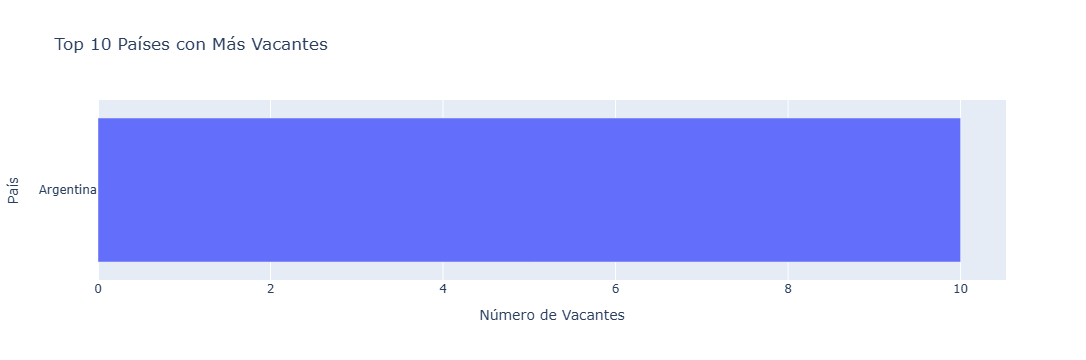

In [4]:
if not df_jobs.empty and 'country' in df_jobs.columns:
    country_counts = df_jobs['country'].value_counts().reset_index()
    country_counts.columns = ['País', 'Número de Vacantes']
    fig = px.bar(country_counts.head(10), x='Número de Vacantes', y='País', orientation='h',
                 title='Top 10 Países con Más Vacantes',
                 color_continuous_scale=px.colors.sequential.Plasma)
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    fig.show()
else:
    print("No hay datos de país para visualizar.")

### 3.2. Vacantes por Sector

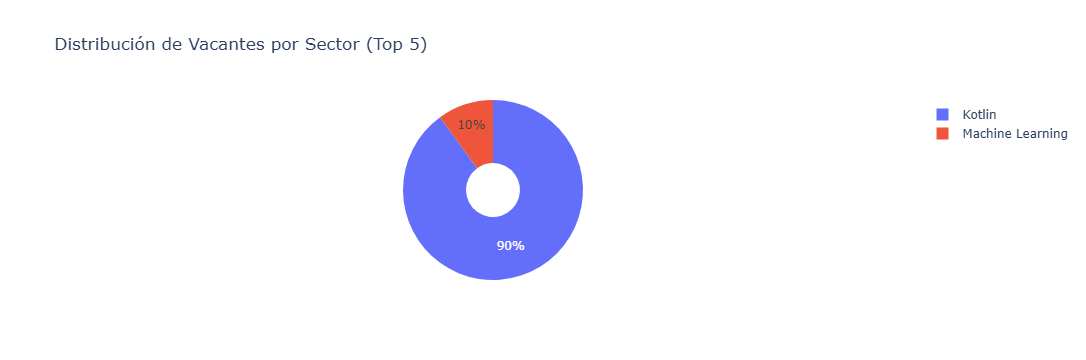

In [5]:
if not df_jobs.empty and 'sector' in df_jobs.columns:
    sector_counts = df_jobs['sector'].value_counts().reset_index()
    sector_counts.columns = ['Sector', 'Número de Vacantes']
    fig = px.pie(sector_counts.head(5), values='Número de Vacantes', names='Sector',
                 title='Distribución de Vacantes por Sector (Top 5)',
                 hole=0.3)
    fig.show()
else:
    print("No hay datos de sector para visualizar.")

### 3.3. Habilidades Más Demandadas (Basado en datos crudos de `jobs`)

Aquí visualizamos las habilidades más frecuentes directamente de las vacantes, para ver la demanda general.

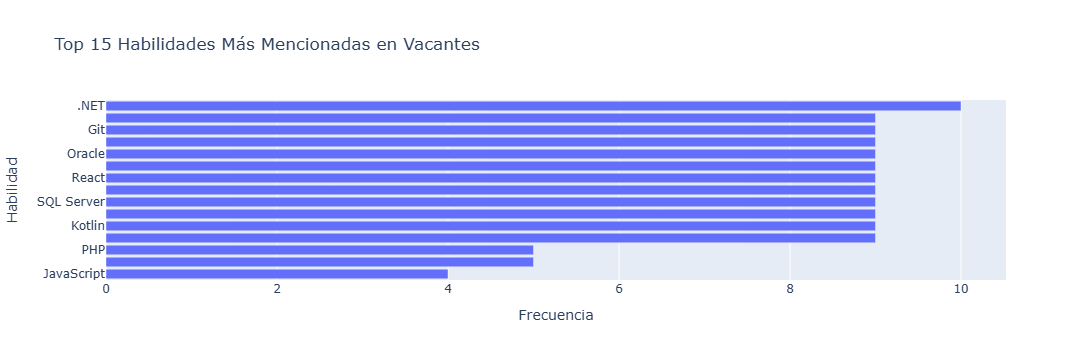

In [6]:
if not df_skills.empty and 'skill_name' in df_skills.columns:
    demanded_skills = df_skills['skill_name'].value_counts().reset_index()
    demanded_skills.columns = ['Habilidad', 'Frecuencia']
    fig = px.bar(demanded_skills.head(15), x='Frecuencia', y='Habilidad', orientation='h',
                 title='Top 15 Habilidades Más Mencionadas en Vacantes',
                 color_continuous_scale=px.colors.sequential.Blues)
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    fig.show()
else:
    print("No hay datos de habilidades para visualizar.")

### 3.4. Roles Más Demandados (Basado en datos crudos de `jobs`)

Similar a las habilidades, podemos ver los roles que más aparecen en los títulos de las vacantes.

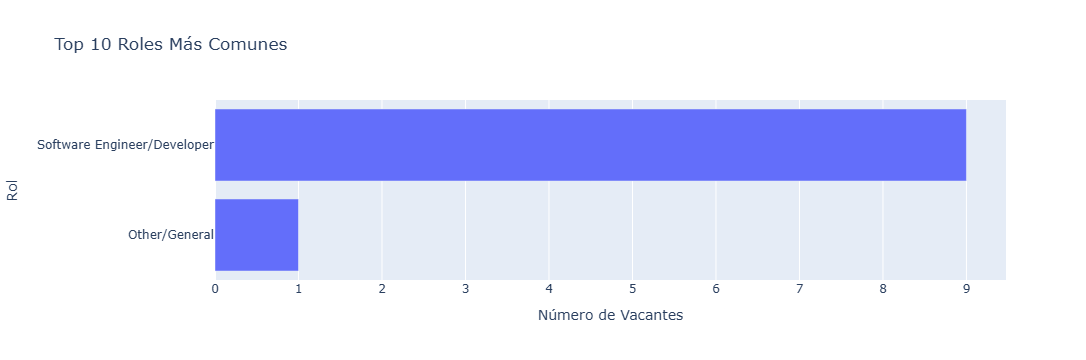

In [7]:
if not df_jobs.empty and 'title' in df_jobs.columns:
    # Una simplificación básica de roles para este análisis
    def simplify_title_for_roles(title):
        title_lower = str(title).lower()
        if 'software engineer' in title_lower or 'ingeniero de software' in title_lower or 'desarrollador' in title_lower: return 'Software Engineer/Developer'
        if 'data scientist' in title_lower or 'científico de datos' in title_lower: return 'Data Scientist'
        if 'product manager' in title_lower or 'gerente de producto' in title_lower: return 'Product Manager'
        if 'devops' in title_lower: return 'DevOps Engineer'
        if 'frontend' in title_lower: return 'Frontend Developer'
        if 'backend' in title_lower: return 'Backend Developer'
        if 'full stack' in title_lower: return 'Full Stack Developer'
        return 'Other/General'

    df_jobs['simplified_role'] = df_jobs['title'].apply(simplify_title_for_roles)
    role_counts = df_jobs['simplified_role'].value_counts().reset_index()
    role_counts.columns = ['Rol', 'Número de Vacantes']
    fig = px.bar(role_counts.head(10), x='Número de Vacantes', y='Rol', orientation='h',
                 title='Top 10 Roles Más Comunes',
                 color_continuous_scale=px.colors.sequential.Oranges)
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    fig.show()
else:
    print("No hay datos de títulos de vacantes para analizar roles.")

### 3.5. Tendencias de Habilidades (Desde la tabla `trends`)

Aquí usamos los datos pre-calculados de la tabla `trends` para ver las habilidades en crecimiento.

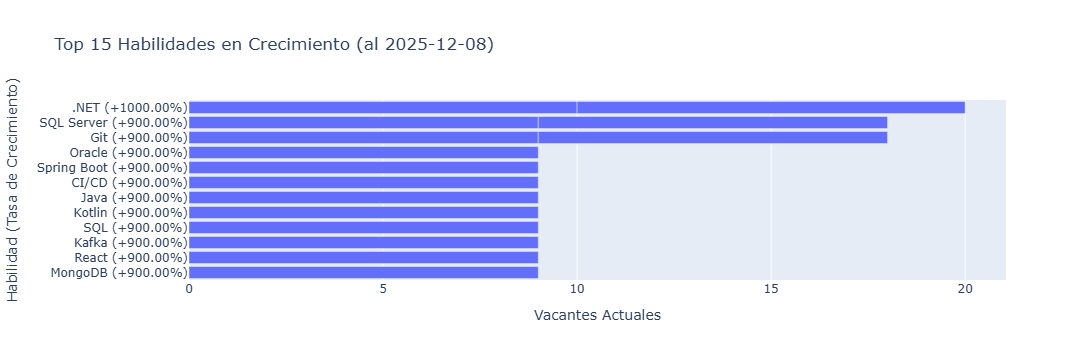

In [8]:
if not df_trends.empty:
    # Tomar las tendencias más recientes (del último día de análisis)
    latest_analysis_date = df_trends['date'].max()
    latest_trends = df_trends[df_trends['date'] == latest_analysis_date]

    growing_skills_trend = latest_trends[latest_trends['metric_name'] == 'growing_skill'].sort_values('count', ascending=False)
    
    if not growing_skills_trend.empty:
        fig = px.bar(growing_skills_trend.head(15), x='count', y='metric_value', orientation='h',
                     title=f'Top 15 Habilidades en Crecimiento (al {latest_analysis_date.strftime("%Y-%m-%d")})',
                     labels={'count': 'Vacantes Actuales', 'metric_value': 'Habilidad (Tasa de Crecimiento)'},
                     color_continuous_scale=px.colors.sequential.Greens)
        fig.update_layout(yaxis={'categoryorder':'total ascending'})
        fig.show()
    else:
        print("No hay datos de habilidades en crecimiento en la tabla de tendencias.")
else:
    print("La tabla de tendencias está vacía. Ejecuta el análisis de tendencias con `python main.py --analyze-trends`.")

## 4. Conclusión

Este notebook proporciona una visión básica del mercado laboral LatAm basada en los datos scrapeados. Puedes extender este análisis para:
- Segmentar por país o sector.
- Comparar tendencias a lo largo de diferentes períodos.
- Realizar un análisis de texto más profundo en descripciones de vacantes.
- Integrar otras fuentes de datos.